In [2]:
import pandas as pd 
import numpy as np 
import pickle
from matplotlib import pyplot as plt

def load_weights(file_path):
    with open('../weights/weights.pkl', 'rb') as f:
        params = pickle.load(f)
    print('weights and biases imported from file')
    return params['W1'], params['b1'], params['W2'], params['b2']

W1, b1, W2, b2 = load_weights('weights.pkl')

weights and biases imported from file


In [18]:
'''Getting data from finetune.csv'''

data = pd.read_csv('../data/finetune.csv', header=None)

data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

tenpercent = len(data) - int(0.9*len(data))

data_dev = data[0:tenpercent].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]

data_train = data[tenpercent:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
_,m_train = X_train.shape

In [3]:
'''Getting data from mongodb'''
from pymongo import MongoClient
from dotenv import load_dotenv
import os

load_dotenv()
MONGO_URI = os.getenv("MONGO_URI", 'mongodb://localhost:27017/')
client = MongoClient(MONGO_URI)
db = client["finetune"]
collection = db["finetune_data"]

def load_data_from_mongo():
    data = list(collection.find())
    images = np.array([np.array(doc['image']) for doc in data]).T
    labels = np.array([doc['label'] for doc in data])

    indices = np.random.permutation(images.shape[1])
    images = images[:, indices]
    labels = labels[indices]

    split = int(0.9 * images.shape[1])
    X_train, X_dev = images[:, :split], images[:, split:]
    Y_train, Y_dev = labels[:split], labels[split:]

    return X_train, Y_train, X_dev, Y_dev

X_train, Y_train, X_dev, Y_dev = load_data_from_mongo()

print(f"Training data shape: {X_train.shape}")
print(f"Dev data shape: {X_dev.shape}")

Training data shape: (784, 154)
Dev data shape: (784, 18)


In [4]:
def ReLU(z):
    return np.maximum(0, z)

def ReLU_deriv(z):
    return z > 0

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True)) #for numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y, num_classes=10):
    one_hot_Y = np.zeros((Y.size, num_classes))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = X.shape[1]
    one_hot_Y = one_hot(Y, num_classes=A2.shape[0])

    dZ2 = A2 - one_hot_Y
    dW2 = (1 / m) * dZ2.dot(A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = (1 / m) * dZ1.dot(X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

# Helper functions
def get_predictions(A2):
    return np.argmax(A2, axis=0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [5]:
def fine_tune(W1, b1, W2, b2, X_train, y_train, X_dev, y_dev, alpha, iterations):

    for i in range(iterations):

        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_train)
        
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_train, y_train)
        
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 1 == 0:
            train_preds = get_predictions(A2)
            train_acc = get_accuracy(train_preds, y_train)
            
            _, _, _, dev_A2 = forward_prop(W1, b1, W2, b2, X_dev)
            dev_preds = get_predictions(dev_A2)
            dev_acc = get_accuracy(dev_preds, y_dev)
            
            print(f"Iteration {i}: Train Accuracy: {train_acc:.4f}, Dev Accuracy: {dev_acc:.4f}")
    return W1, b1, W2, b2

In [6]:
Y_train = Y_train.astype(int)
Y_dev = Y_dev.astype(int)

In [42]:
alpha = 0.01
iterations = 30
W1, b1, W2, b2 = fine_tune(W1, b1, W2, b2, X_train, Y_train, X_dev, Y_dev, alpha, iterations)

Iteration 0: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 1: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 2: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 3: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 4: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 5: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 6: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 7: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 8: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 9: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 10: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 11: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 12: Train Accuracy: 0.9610, Dev Accuracy: 0.8333
Iteration 13: Train Accuracy: 0.9675, Dev Accuracy: 0.8333
Iteration 14: Train Accuracy: 0.9675, Dev Accuracy: 0.8333
Iteration 15: Train Accuracy: 0.9675, Dev Accuracy: 0.8333
Iteration 16: Train Accuracy: 0.9675, Dev Accuracy: 0.8333
Iterati

In [44]:
fine_tuned_params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
with open('../weights/finetuned_weights.pkl', 'wb') as f:
    pickle.dump(fine_tuned_params, f)

print("Fine-tuning complete. Parameters saved.")

Fine-tuning complete. Parameters saved.


In [72]:
#for testing purposes only
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [1]
Label:  1


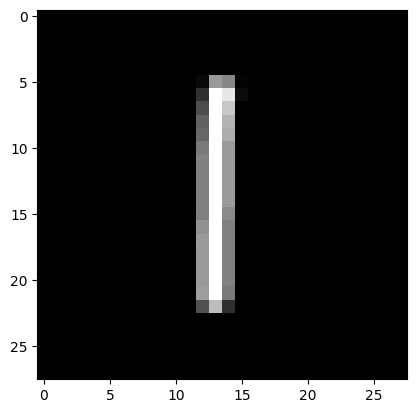

Prediction:  [6]
Label:  6


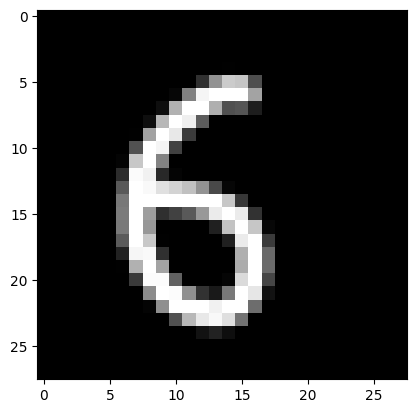

Prediction:  [4]
Label:  4


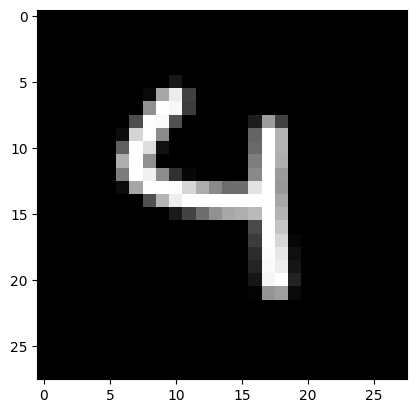

Prediction:  [8]
Label:  8


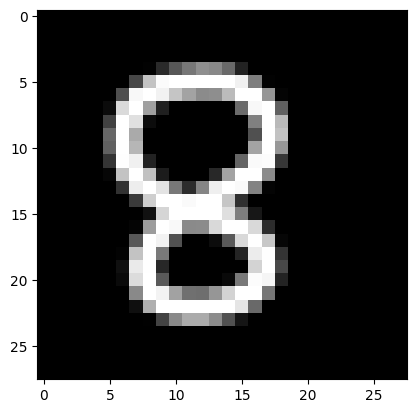

Prediction:  [3]
Label:  3


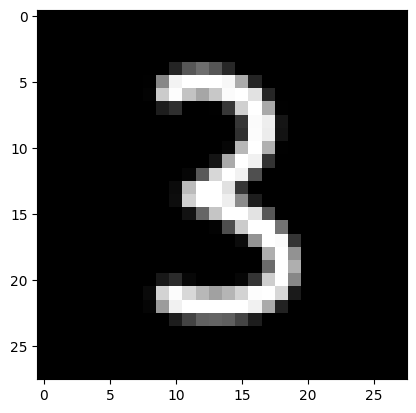

Prediction:  [5]
Label:  5


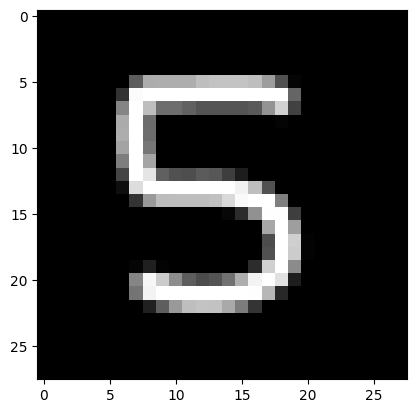

Prediction:  [0]
Label:  0


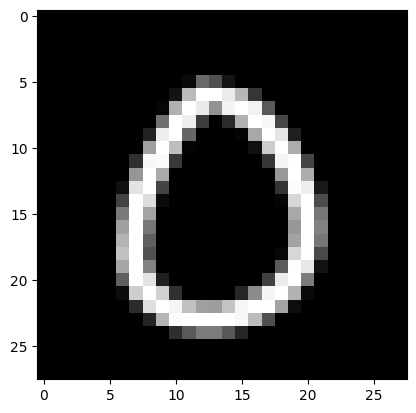

Prediction:  [0]
Label:  0


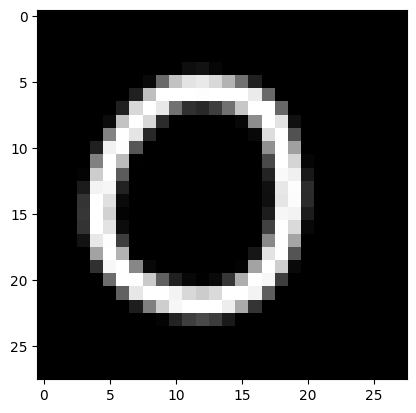

Prediction:  [3]
Label:  3


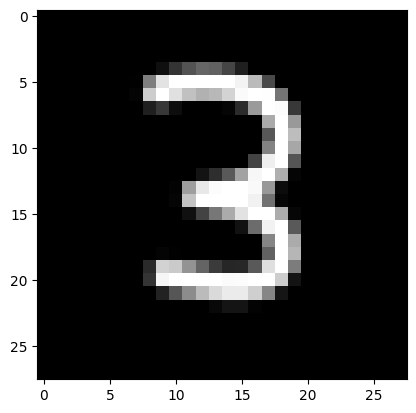

Prediction:  [3]
Label:  3


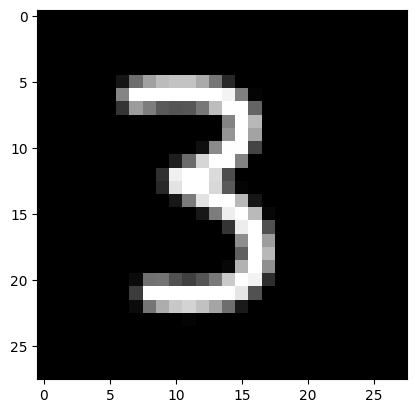

Prediction:  [6]
Label:  6


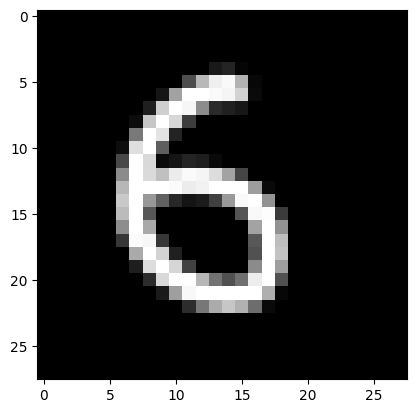

Prediction:  [0]
Label:  0


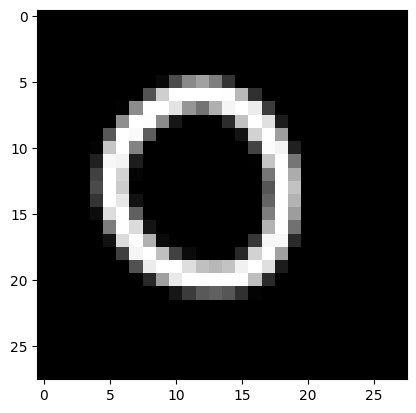

Prediction:  [2]
Label:  2


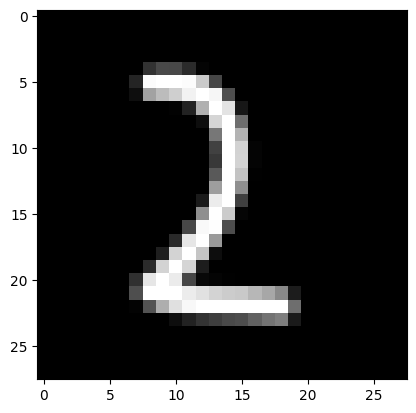

Prediction:  [7]
Label:  7


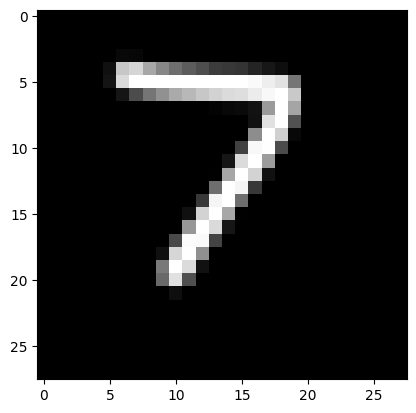

Prediction:  [5]
Label:  5


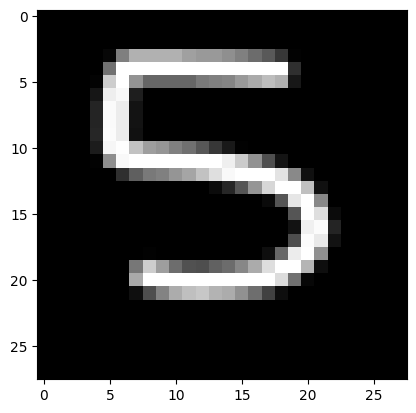

Prediction:  [7]
Label:  7


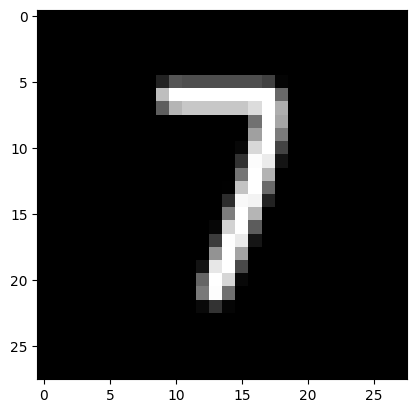

Prediction:  [5]
Label:  5


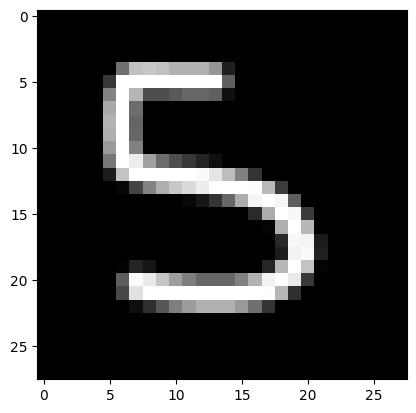

Prediction:  [3]
Label:  3


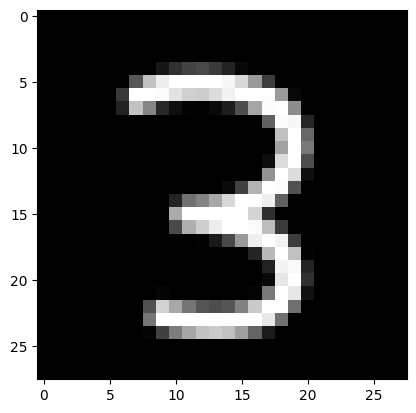

Prediction:  [4]
Label:  4


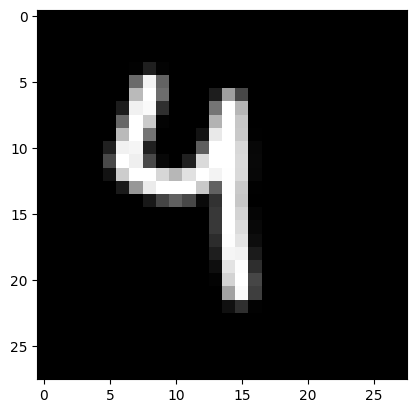

Prediction:  [9]
Label:  9


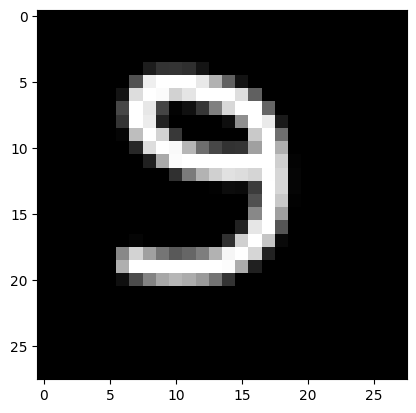

In [73]:
for i in range(40):
    test_prediction(i, W1, b1, W2, b2)